In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

%matplotlib inline

## SMO算法

SVM的理论推导太难了，看了半天也没搞明白(需要的数学知识太多)，我还是放弃吧，下面是网上找的一个简易smo算法，自己都没看懂。

这个算法，了解推导过程，明白原理就好。现在没时间看这么深奥的数学内容，先会用SVM吧。

In [3]:
# https://www.cnblogs.com/hanzi5/p/10105614.html
# 简易smo算法开始####################################################################
# 随机选择第2个alpha
def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(np.random.uniform(0,m))
    return j

# 调整大于H或小于L的alpha值
def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

# 公共函数，根据公式求w，简易smo算法及完整smo算法通用
def calcWs(alphas,dataArr,labelArr):
    w=sum( np.array(alphas) * np.array(labelArr.reshape((-1,1))) * np.array(np.array(dataArr))  )
    return w


# 输入变量：x、y、c：常数c、toler：容错率、maxIter：最大循环次数
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    #dataMatIn, classLabels, C, toler, maxIter=dataArr,lableArr,0.6,0.001,40
    dataMatrix = np.mat(dataMatIn)             # 数据x转换为matrix类型
    labelMat = np.mat(classLabels).transpose() # 标签y转换为matrix类型，转换为一列
    b = 0                                      # 截距b
    m,n = np.shape(dataMatrix)                 # 数据x行数、列数
    alphas = np.mat(np.zeros((m,1)))           # 初始化alpha，有多少行数据就产生多少个alpha
    iter = 0                                   # 遍历计数器
    while (iter < maxIter):
        #print( "iteration number: %d" % iter)
        alphaPairsChanged = 0                  # 记录alpha是否已被优化，每次循环都重置
        for i in range(m):                     # 按行遍历数据，类似随机梯度下降
            # i=0
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b # 预测值y，g(x)函数，《统计学习方法》李航P127，7.104
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions  # 误差，Ei函数，P127，7.105
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                # 找第一个alphas[i]，找到第一个满足判断条件的，判断负间隔or正间隔，并且保证0<alphas<C
                j = selectJrand(i,m)            # 随机找到第二个alphas[j]
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b # 计算预测值
                Ej = fXj - float(labelMat[j])   # 计算alphas[j]误差
                alphaIold = alphas[i].copy()    # 记录上一次alphas[i]值
                alphaJold = alphas[j].copy()    # 记录上一次alphas[j]值
                if (labelMat[i] != labelMat[j]):# 计算H及L值，《统计学习方法》李航，P126
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: 
                    #print( "L==H")
                    continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                # 《统计学习方法》李航P127，7.107，这里的eta与李航的一致，这里乘了负号
                if eta >= 0: 
                    #print("eta>=0")
                    continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta     # 《统计学习方法》李航P127，7.107，更新alphas[j]
                alphas[j] = clipAlpha(alphas[j],H,L)       # alphas[j]调整大于H或小于L的alpha值
                if (abs(alphas[j] - alphaJold) < 0.00001): # 调整后过小，则不更新alphas[i]
                    #print( "j not moving enough")
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j]) #更新alphas[i]，《统计学习方法》李航P127，7.109
                # 更新b值，《统计学习方法》李航P130，7.115，7.116
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): # 判断符合条件的b
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else: 
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                #print( "iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0):
            iter += 1
        else:
            iter = 0
    return b,alphas

In [4]:
from sklearn import datasets

((100, 2), (100,))

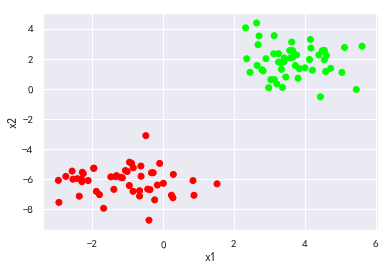

In [25]:
X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2)

plt.scatter(X[:,0], X[:,1], c=np.where(y==0, "#ff0000", "#00ff00") )
plt.xlabel("x1")
plt.ylabel("x2")

X.shape, y.shape

In [26]:
y_ = np.where(y==0,-1,1)
b, alphas =smoSimple(X,y_,0.6,0.001,100)
# 根据alpha求w
w = calcWs(alphas,X,y_) 

b, w

(matrix([[0.05000182]]), array([0.31204708, 0.28791412]))

In [27]:
b[0,0]

0.050001822013341087

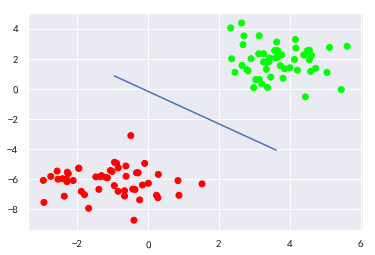

In [28]:
plt.scatter(X[:,0], X[:,1], c=np.where(y==0, "#ff0000", "#00ff00") )

x = np.linspace(X[:,0].min()+2, X[:,0].max()-2, 1000)
plt.plot(x, -(w[0]*x + b[0,0])/w[1] )

In [29]:
dataWithAlpha = np.array(np.concatenate((X,y_.reshape(-1,1),alphas.reshape(-1,1)),axis=1)) # 把alphas1与原始数据合并
dataWithAlpha[dataWithAlpha[:,-1]>0] # 支持向量

array([[-4.80520865e-01, -3.12612905e+00, -1.00000000e+00,
         9.01339603e-02],
       [ 1.52564289e+00, -6.33703826e+00, -1.00000000e+00,
         9.02056208e-17],
       [-9.04335299e-02, -4.97657394e+00, -1.00000000e+00,
         4.85722573e-17],
       [ 2.98151587e+00,  6.81621627e-02,  1.00000000e+00,
         9.01339603e-02],
       [-6.20059687e-01, -5.15047082e+00, -1.00000000e+00,
         1.38777878e-17]])

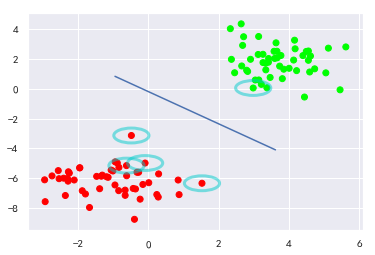

In [30]:
from matplotlib.patches import Circle

fig,ax = plt.subplots(1,1)
x = np.linspace(X[:,0].min()+2, X[:,0].max()-2, 1000)
plt.plot(x, -(w[0]*x + b[0,0])/w[1] )

# 获取支持向量值，画椭圆
ax.scatter(X[:,0], X[:,1], c=np.where(y==0, "#ff0000", "#00ff00") )
dataVectors=dataWithAlpha[dataWithAlpha[:,-1]>0]
for d in dataVectors:
    circle = Circle(d[0:2], 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)